# Attention and Conditionality

> In this module, we implement attention and conditionality

Adapted from

- [https://youtu.be/DH5bp6zTPB4?si=ziAq_45vkifFx1R4&t=2942](https://youtu.be/DH5bp6zTPB4?si=ziAq_45vkifFx1R4&t=2942)

In [1]:
#| default_exp attention

In [2]:
# |export
import math
from functools import partial

import torch
import torch.nn.functional as F
from einops import rearrange
from torch import nn, tensor
from torch.optim import lr_scheduler
from tqdm import tqdm

from slowai.cos_revisited import aesthetics, denoisify, noisify
from slowai.ddpm import get_dls as get_fashion_dls
from slowai.diffusion_unet import Conv, TDownblock, TUnet, TUpblock, ddpm, train
from slowai.learner import DeviceCB, Learner, MetricsCB, ProgressCB, TrainCB, def_device
from slowai.sgd import BatchSchedulerCB
from slowai.utils import show_images

In [3]:
# |hide
aesthetics()

Attention is a "high-pass" filter that can help with the limitations of a "low-pass" filter such as a convolution.

Huggingface diffusers implements a 1D-attention by rasterizing the image, which is how we will implement this (although this is known to be "suboptimal," accourding to Howard.) Then, each pixel has a $C$-dimensional embedding.

Johno mentions that softmax tends to assign all weight to a single dimension, but this is often undesirable. Multi-headedness compensates for this by creating many orthoganol subspaces within which attention is assigned.

See [jer.fish/posts/notes-on-self-attention](https://www.jer.fish/posts/notes-on-self-attention/) for more details.

In [4]:
# |export
class MultiheadSelfAttention1D(nn.Module):
    """Multi-head self-attention"""

    def __init__(self, nc, nh):
        super().__init__()
        self.nc = nc
        self.nh = nh
        self.norm = nn.BatchNorm2d(nc)
        self.kqv = nn.Linear(nc, nc * 3)
        self.lin = nn.Linear(nc, nc)

    def forward(self, x):
        _, _, h, w = x.shape
        # Normalize
        x = self.norm(x)
        # Rasterize
        x = rearrange(x, "b c h w -> b (h w) c")
        # Project into a K, Q, V space
        x = self.kqv(x)
        # Divide into different heads of K, Q and V
        k, q, v = rearrange(x, "b t (nh hs kqv) -> kqv (b nh) t hs", nh=self.nh, kqv=3)
        # Compute affinity
        affinity_scores = k @ q.transpose(1, 2)
        affinity_scores /= math.sqrt(self.nc / self.nh)
        affinity = affinity_scores.softmax(dim=2)
        # Re-weight V by the affinity matrix
        x = affinity @ v
        # Concatenate the heads
        x = rearrange(x, "(b nh) t hs -> b t (nh hs)", nh=self.nh)
        # Share information channel-wise (instead of time-wise)
        x = self.lin(x)
        # Un-rasterize
        x = rearrange(x, "b (h w) c -> b c h w", h=h, w=w)
        return x

In [5]:
attn = MultiheadSelfAttention1D(nc=32, nh=4)

In [6]:
x = torch.randn(8, 32, 16, 16)
attn(x).shape

torch.Size([8, 32, 16, 16])

In [7]:
# |hide
del attn

Let's use this in a **Diffusion UNet**.  Note that we cannot use attention near the beginning or head due to the quadratic time and space capacity (there are more time steps at these points). Typically, attention is only used when the feature map is 16x16 or 32x32 or higher.

In [ ]:
# |export
class TAResBlock(nn.Module):
    """Res-block with attention"""

    def __init__(self, t_embed, c_in, c_out, ks=3, stride=2, nh=None):
        super().__init__()
        self.t_embed = t_embed
        self.c_in = c_in
        self.c_out = c_out

        self.t_emb_proj = nn.Linear(t_embed, c_out * 2)
        self.conv_a = Conv(c_in, c_out)
        self.conv_b = Conv(c_out, c_out)

        if c_in != c_out:
            self.id_conv = nn.Conv2d(c_in, c_out, kernel_size=1)
        else:
            self.id_conv = None

        if nh:
            self.attn = MultiheadSelfAttention1D(c_out, nh)
        else:
            self.attn = None

    def forward(self, x_orig, t_emb):
        # non-residual link
        x = self.conv_a(x_orig)
        t_emb = self.t_emb_proj(F.relu(t_emb))[:, :, None, None]
        scale, shift = torch.chunk(t_emb, 2, dim=1)
        x = x * (1 + scale) + shift
        x = self.conv_b(x)

        # residual link
        xr = self.id_conv(x_orig) if self.id_conv else x_orig

        x = x + xr

        if self.attn:
            x = x + self.attn(x)

        self.output = x

        return x

In [9]:
# |export
class TADownblock(TDownblock):
    """Resdownblock with attention"""

    def __init__(self, t_embed, c_in, c_out, downsample=True, n_layers=1, nh=None):
        super().__init__(t_embed, c_in, c_out, downsample, n_layers)

        # Use the new Attention ResBlocks
        self.convs = nn.ModuleList()
        self.convs.append(TAResBlock(t_embed, c_in, c_out, stride=1, nh=nh))
        for _ in range(n_layers - 1):
            self.convs.append(TAResBlock(t_embed, c_out, c_out, stride=1, nh=nh))
        self.downsampler = nn.Conv2d(c_out, c_out, kernel_size=3, stride=2, padding=1)

In [10]:
# |export
class TAUpblock(TUpblock):
    """Resupblock with attention"""

    def __init__(self, t_embed, c_in, c_out, upsample=True, n_layers=1, nh=None):
        super().__init__(t_embed, c_in, c_out, upsample, n_layers)

        # Use the new Attention ResBlocks
        self.convs = nn.ModuleList()
        for _ in range(n_layers - 1):
            self.convs.append(TAResBlock(t_embed, c_in * 2, c_in, stride=1))
        self.convs.append(TAResBlock(t_embed, c_in * 2, c_out, stride=1))

In [11]:
# |export
class TAUnet(TUnet):
    """U-net with attention up/down-blocks"""

    def __init__(
        self,
        nfs=(224, 448, 672, 896),
        attention_heads=(0, 8, 8, 8),
        n_blocks=(3, 2, 2, 1, 1),
        color_channels=3,
    ):
        assert len(n_blocks) == len(attention_heads) == len(nfs) + 1
        super().__init__(nfs, n_blocks, color_channels)
        self.downblocks = nn.ModuleList()
        self.upblocks = nn.ModuleList()
        for c_in, c_out, n_layers, nh in zip(nfs, nfs[1:], n_blocks, attention_heads):
            db = TADownblock(
                self.time_embedding.c_out,
                c_in,
                c_out,
                n_layers=n_layers,
                nh=nh,
            )
            self.downblocks.append(db)
            self.upblocks.insert(0, TAUpblock.from_downblock(db))

In [ ]:
# |hide
# TODO: Add kaiming initialization for attention layer

In [12]:
dls = get_fashion_dls(512)

loss,epoch,train
0.282,0,train
0.114,0,eval
0.084,1,train
0.073,1,eval
0.059,2,train
0.055,2,eval
0.048,3,train
0.045,3,eval
0.042,4,train
0.045,4,eval


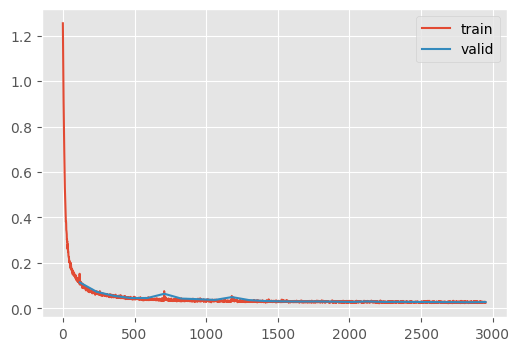

CPU times: user 16min 3s, sys: 2min 6s, total: 18min 9s
Wall time: 18min 16s


In [13]:
%%time
un = train(
    TAUnet(
        color_channels=1,
        nfs=(32, 64, 128, 256, 384),
        n_blocks=(3, 2, 1, 1, 1, 1),
        attention_heads=(0, 8, 8, 8, 8, 8),
    ),
    dls,
    lr=1e-3,
    n_epochs=25,
)

100%|██████████████████████████████████████████████████████████| 249/249 [00:01<00:00, 130.57time step/s]


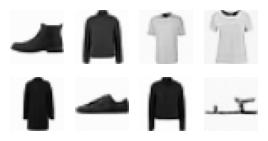

In [14]:
x_0, _ = ddpm(un, (8, 1, 32, 32), n_steps=100)
show_images(x_0, imsize=0.8)

In [15]:
del un

# Adding conditionality

In [16]:
# |export
class ConditionalTAUnet(TAUnet):
    def __init__(
        self,
        n_classes,
        nfs=(224, 448, 672, 896),
        attention_heads=(0, 8, 8, 8),
        n_blocks=(3, 2, 2, 1, 1),
        color_channels=3,
    ):
        super().__init__(nfs, attention_heads, n_blocks, color_channels)
        self.conditional_embedding = nn.Embedding(n_classes, self.time_embedding.c_out)

    def forward(self, x_t, t, c):
        t = self.time_embedding(t)
        c = self.conditional_embedding(c)  # 👈
        e = t + c
        x = self.start(x_t)
        for db in self.downblocks:
            x = db(x, t)
        x = self.middle(x, e)
        for ub, db in zip(self.upblocks, reversed(self.downblocks)):
            x = ub(x, db, e)
        return self.end(x)

In [17]:
# |export
class ConditionalFashionDDPM(TrainCB):
    def before_batch(self, learn):
        x0, c = learn.batch
        (x_t, t), epsilon = noisify(x0)
        learn.batch = (x_t, t, c), epsilon

    def predict(self, learn):
        (x_t, t, c), _ = learn.batch
        learn.preds = learn.model(x_t, t, c)

    def get_loss(self, learn):
        _, epsilon = learn.batch
        learn.loss = learn.loss_func(learn.preds, epsilon)

In [18]:
# |export
def conditional_train(
    model, dls, lr=4e-3, n_epochs=25, extra_cbs=[], loss_fn=F.mse_loss
):
    T_max = len(dls["train"]) * n_epochs
    scheduler = BatchSchedulerCB(lr_scheduler.OneCycleLR, max_lr=lr, total_steps=T_max)
    cbs = [
        DeviceCB(),
        ProgressCB(plot=True),
        scheduler,
        MetricsCB(),
        DeviceCB(),
        ConditionalFashionDDPM(),  # 👈
        *extra_cbs,
    ]
    learner = Learner(
        model,
        dls,
        loss_fn,
        lr=lr,
        cbs=cbs,
        opt_func=partial(torch.optim.AdamW, eps=1e-5),
    )
    learner.fit(n_epochs)
    return model

loss,epoch,train
0.158,0,train
0.087,0,eval
0.058,1,train
0.056,1,eval
0.045,2,train
0.054,2,eval
0.039,3,train
0.042,3,eval
0.036,4,train
0.050,4,eval


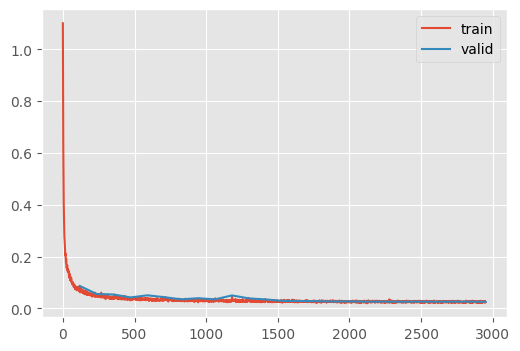

CPU times: user 16min 1s, sys: 2min 6s, total: 18min 8s
Wall time: 18min 16s


In [19]:
%%time
un = conditional_train(
    ConditionalTAUnet(
        n_classes=10,
        color_channels=1,
        nfs=(32, 64, 128, 256, 384),
        n_blocks=(3, 2, 1, 1, 1, 1),
        attention_heads=(0, 8, 8, 8, 8, 8),
    ),
    dls,
    lr=4e-3,
    n_epochs=25,
)

In [20]:
# |export
@torch.no_grad()
def conditional_ddpm(model, c, sz=(16, 1, 32, 32), device=def_device, n_steps=100):
    x_0s = []
    x_t = torch.randn(sz, device=device)
    c = c.to(device)
    ts = torch.linspace(1 - (1 / n_steps), 0, n_steps).to(device)
    for t, t_next in tqdm(zip(ts, ts[1:]), unit="time step", total=n_steps - 1):
        # Predict the noise for each example in the image
        bs, *_ = x_t.shape
        noise_pred = model(x_t, t.repeat(bs), c)

        # Predict the image without noise
        x_0_pred = denoisify(x_t, noise_pred, t)
        x_0s.append(x_0_pred)

        # Renoise
        (prev_sample, _), _ = noisify(x_0_pred, t_next)

        # Repeat
        x_t = prev_sample

    # At the last step, simply rescale and do not add noise
    t = tensor(0.0, device=device).repeat(bs)
    x_0 = denoisify(x_t, model(x_t, t, c), t)
    x_0s.append(x_0_pred)

    return x_0, x_0s

100%|████████████████████████████████████████████████████████████| 99/99 [00:00<00:00, 119.07time step/s]


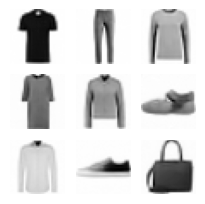

In [21]:
c = torch.arange(0, 9)
x_0, _ = conditional_ddpm(un, c, (9, 1, 32, 32))
show_images(x_0, imsize=0.8);

100%|████████████████████████████████████████████████████████████| 99/99 [00:00<00:00, 131.05time step/s]


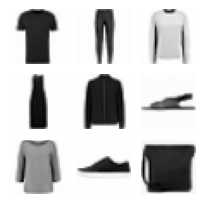

In [30]:
x_0, _ = conditional_ddpm(un, c, (9, 1, 32, 32))
show_images(x_0, imsize=0.8);

In [33]:
# |hide
torch.save(un, "../models/conditional-attention-unet.pt")

In [1]:
#| hide
import nbdev

nbdev.nbdev_export()